# <center>АНАЛИЗ ЗВУКА И ГОЛОСА</center>

**Преподаватель**: Рыбин Сергей Витальевич

**Группа**: 6304

**Студент**: Белоусов Евгений Олегович

## <center>Классификация эмоций</center>

*Необоходимый результат: неизвестно*

In [ ]:
import os
import IPython
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

In [ ]:
from tqdm.notebook import tqdm

from tensorflow.keras import losses, models, optimizers
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint, TensorBoard)
from tensorflow.keras.layers import (Input, Dense, Convolution2D, BatchNormalization,
                                     Flatten, MaxPool2D, Activation)
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Ручная часть работы - директория с набором аудиофайлов, набор меток классов, учёт разновидностей имён файлов
predictions = "predictions"
directory = "./content/drive/MyDrive/Training/"

labels = ["angry",
          "chilled",
          "happy",
          "neutral",
          "sad"]

num_classes = len(labels)

In [ ]:
# Параметры конфигурации для будущей модели нейросети
class Config(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=7, n_classes=10, use_mfcc=True,
                 n_mfcc=20, n_folds=10, n_features=100, learning_rate=0.0001, max_epochs=50):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.n_mfcc = n_mfcc
        self.n_folds = n_folds
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.n_features = n_features
        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length / 512)), 1)
        else:
            self.dim = (self.audio_length, 1)

In [ ]:
# Подготовка датафрейма
def prepare_dataframe(directory, folder, df):
    dirpath = directory + folder
    files = ([f.path for f in os.scandir(dirpath) if f.is_file()])
    # Создание датафрейма по предоставленной в условии задачи схеме

    # Проход по всем аудиофайлам в наборе
    for path in tqdm(files[:]):
        filename = os.path.splitext(os.path.basename(path).strip())[0]
        label = folder
        
        # Добавляем обработанный аудиофайл в датафрейм
        row = pd.Series([filename, label], index = df.columns)
        df = df.append(row, ignore_index=True)
    
    return df

In [ ]:
# Извлечение признаков из набора аудиофайлов
def prepare_data(config, directory, folder, X):
    dirpath = directory + folder
    files = ([f.path for f in os.scandir(dirpath) if f.is_file()])

    # Задаём длительность аудиофайла
    input_length = config.audio_length

    i = 0
    # Проход по всем аудиофайлам в наборе
    for path in tqdm(files[:]):
        filename = os.path.splitext(os.path.basename(path).strip())[0]

        data, sr = librosa.load(path, sr=config.sampling_rate)

        # Обрезка/приведение длительности аудиофайла к указанной в параметрах конфигурации
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        
        # Извлечение признаков MFCC с помощью библиотеки librosa
        data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
        data = np.expand_dims(data, axis=-1)
        X[i,] = data
        i = i + 1

    return X

In [ ]:
# Модель свёрточной нейросети
def get_2d_conv_model(config):
    num_classes = config.n_classes
    
    inp = Input(shape=(config.dim[0], config.dim[1], 1))
    
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    out = Dense(num_classes, activation=softmax)(x)
    
    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)
    model.compile(optimizer=opt, loss=losses.SparseCategoricalCrossentropy(), metrics=['acc'])
    
    return model

In [ ]:
# Матрица ошибок классификации
def plot_confusion_matrix(predictions, y):
    max_test = y
    max_predictions = np.argmax(predictions, axis=1)
    matrix = confusion_matrix(max_test, max_predictions)
    plt.figure(figsize=(12, 8))
    sns.heatmap(matrix, xticklabels=labels, yticklabels=labels, annot=True,
                linewidths = 0.1, fmt="d", cmap = 'YlGnBu');
    plt.title("Матрица ошибок классификации", fontsize = 15)
    plt.ylabel("Настоящий класс")
    plt.xlabel("Предсказанный")
    plt.show()

In [ ]:
# Подготовим датафрейм
df = pd.DataFrame(columns=["filename", "label"])
for label in labels:
    df = prepare_dataframe(directory, label, df)

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

In [ ]:
df.head(-5)

,filename,label
0,Track 001,angry
1,Track 002,angry
2,Track 003,angry
3,Track 004,angry
4,Track 005,angry
...,...,...
849,Track 850,sad
850,Track 851,sad
851,Track 852,sad
852,Track 853,sad


In [ ]:
# Сериализуем датафрейм в целях дальнейшей экономии времени
df.to_pickle("./content/drive/MyDrive/SVA_lab_3_dataframe.pkl")

In [ ]:
# Десериализация ранее сохранённого датафрейма
df = pd.read_pickle("./content/drive/MyDrive/SVA_lab_3_dataframe.pkl")

In [ ]:
# Подсчёт количества аудиозаписей каждого класса
df["label"].value_counts()

chilled    259
angry      172
happy      172
sad        171
neutral     85
Name: label, dtype: int64

In [ ]:
# Представим значения меток классов в виде целых чисел
encode = LabelEncoder()
encoded_labels = encode.fit_transform(df['label'].to_numpy())
df = df.assign(label=encoded_labels)

In [ ]:
df.head()

,filename,label
0,Track 001,0
1,Track 002,0
2,Track 003,0
3,Track 004,0
4,Track 005,0


In [ ]:
# Задаём параметры конфигурации
config = Config(n_classes=num_classes, n_folds=10, n_mfcc=20)

In [ ]:
X = np.empty(shape=(df.shape[0], config.dim[0], config.dim[1], 1))
for label in labels:
    X_train = prepare_data(config, directory, label, X)
print(X_train.shape)

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

(859, 20, 219, 1)


In [ ]:
# Нормализация данных

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std

In [ ]:
X_train

array([[[[-1.30768585],
         [-1.30799778],
         [-1.30827631],
         ...,
         [-1.30953685],
         [-1.30810239],
         [-1.30788807]],

        [[-0.03413944],
         [-0.04874218],
         [-0.06391402],
         ...,
         [-0.07903775],
         [-0.05275329],
         [-0.03885148]],

        [[ 0.03413944],
         [ 0.01528027],
         [-0.02119477],
         ...,
         [-0.02496133],
         [-0.06347446],
         [-0.04345496]],

        ...,

        [[-0.03413944],
         [-0.05059676],
         [-0.04435909],
         ...,
         [-0.02384555],
         [-0.01322135],
         [-0.03134292]],

        [[-0.03413944],
         [-0.04734183],
         [-0.06581435],
         ...,
         [ 0.00859894],
         [-0.01384685],
         [-0.03785959]],

        [[-0.03413944],
         [-0.05570205],
         [-0.07244789],
         ...,
         [-0.0369241 ],
         [-0.01449176],
         [-0.03093989]]],


       [[[-1.45342874],


In [ ]:
# ПРОВЕРКА НА ТЕСТОВОМ НАБОРЕ ДАННЫХ

files = ([f.path for f in os.scandir("./content/drive/MyDrive/Test") if f.is_file()])
# Создание датафрейма по предоставленной в условии задачи схеме
submission = pd.DataFrame(columns=["fname"])

# Проход по всем аудиофайлам в наборе
for path in tqdm(files[:]):
    filename = os.path.splitext(os.path.basename(path).strip())[0]
    
    # Добавляем имя аудиофайла в датафрейм
    row = pd.Series([filename], index = submission.columns)
    submission = submission.append(row, ignore_index=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
submission.head()

,fname
0,track_1
1,track_10
2,track_100
3,track_11
4,track_12


In [ ]:
X = np.empty(shape=(submission.shape[0], config.dim[0], config.dim[1], 1))
X_test = prepare_data(config, "./content/drive/MyDrive/", "Test", X)
print(X_test.shape)

  0%|          | 0/100 [00:00<?, ?it/s]

(100, 20, 219, 1)


In [ ]:
# Нормализация данных

mean = np.mean(X_test, axis=0)
std = np.std(X_test, axis=0)

X_test = (X_test - mean)/std

In [ ]:
X_test

array([[[[-1.06515273],
         [-1.06293299],
         [-1.05932428],
         ...,
         [-1.074491  ],
         [-1.06768773],
         [-1.06451263]],

        [[-0.11943239],
         [-0.14272087],
         [-0.138421  ],
         ...,
         [-0.12875129],
         [-0.10666246],
         [-0.10050378]],

        [[-0.02576236],
         [ 0.04677553],
         [ 0.06284138],
         ...,
         [-0.14362502],
         [-0.10702711],
         [-0.10050378]],

        ...,

        [[ 0.05231591],
         [ 0.04391709],
         [-0.03835179],
         ...,
         [-0.16356564],
         [-0.13080131],
         [-0.10050378]],

        [[ 0.03676896],
         [-0.05975129],
         [-0.03827194],
         ...,
         [-0.1646161 ],
         [-0.13033616],
         [-0.10050378]],

        [[-0.13739505],
         [-0.10000917],
         [-0.15979667],
         ...,
         [-0.16689837],
         [-0.13042553],
         [-0.10050378]]],


       [[[ 1.95950129],


In [ ]:
if not os.path.exists(predictions):
    os.mkdir(predictions)
if os.path.exists("./content/drive/MyDrive/" + predictions):
    shutil.rmtree("./content/drive/MyDrive/" + predictions)

##################################################
Fold:  0
Epoch 1/50
3/4 [=====================>........] - ETA: 0s - loss: 1.7237 - acc: 0.1628
Epoch 00001: val_loss improved from inf to 1.59251, saving model to best_0.h5
4/4 [==============================] - 4s 757ms/step - loss: 1.7206 - acc: 0.1656 - val_loss: 1.5925 - val_acc: 0.0930
Epoch 2/50
3/4 [=====================>........] - ETA: 0s - loss: 1.4694 - acc: 0.3802
Epoch 00002: val_loss improved from 1.59251 to 1.53576, saving model to best_0.h5
4/4 [==============================] - 3s 691ms/step - loss: 1.4703 - acc: 0.3803 - val_loss: 1.5358 - val_acc: 0.3721
Epoch 3/50
3/4 [=====================>........] - ETA: 0s - loss: 1.3805 - acc: 0.3971
Epoch 00003: val_loss improved from 1.53576 to 1.49723, saving model to best_0.h5
4/4 [==============================] - 3s 682ms/step - loss: 1.3819 - acc: 0.3959 - val_loss: 1.4972 - val_acc: 0.4070
Epoch 4/50
3/4 [=====================>........] - ETA: 0s - loss: 1.3428 - acc: 

Epoch 30/50
3/4 [=====================>........] - ETA: 0s - loss: 1.1265 - acc: 0.4401
Epoch 00030: val_loss did not improve from 1.32696
4/4 [==============================] - 3s 661ms/step - loss: 1.1272 - acc: 0.4398 - val_loss: 1.3646 - val_acc: 0.4419
Epoch 31/50
3/4 [=====================>........] - ETA: 0s - loss: 1.1207 - acc: 0.4375
Epoch 00031: val_loss did not improve from 1.32696
4/4 [==============================] - 3s 658ms/step - loss: 1.1226 - acc: 0.4360 - val_loss: 1.3679 - val_acc: 0.4302
TRAIN PREDICTIONS:  0


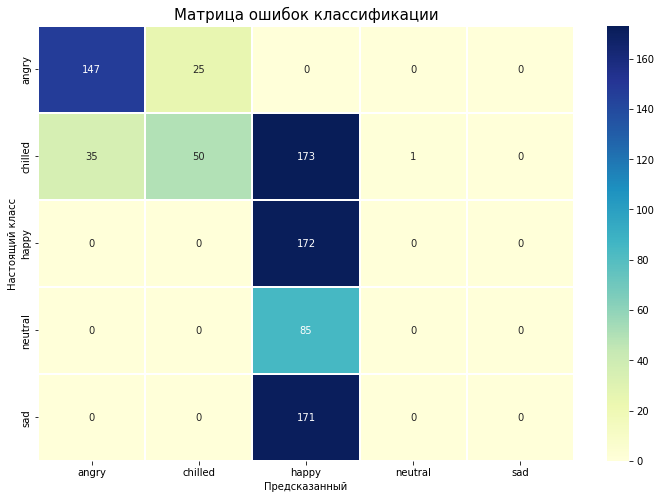

TEST PREDICTIONS:  0
##################################################
Fold:  1
Epoch 1/50
3/4 [=====================>........] - ETA: 0s - loss: 1.6286 - acc: 0.3112
Epoch 00001: val_loss improved from inf to 1.53125, saving model to best_1.h5
4/4 [==============================] - 4s 723ms/step - loss: 1.6275 - acc: 0.3118 - val_loss: 1.5312 - val_acc: 0.2209
Epoch 2/50
3/4 [=====================>........] - ETA: 0s - loss: 1.2988 - acc: 0.4010
Epoch 00002: val_loss improved from 1.53125 to 1.50138, saving model to best_1.h5
4/4 [==============================] - 3s 686ms/step - loss: 1.3006 - acc: 0.4010 - val_loss: 1.5014 - val_acc: 0.2326
Epoch 3/50
3/4 [=====================>........] - ETA: 0s - loss: 1.2287 - acc: 0.4245
Epoch 00003: val_loss improved from 1.50138 to 1.46678, saving model to best_1.h5
4/4 [==============================] - 3s 683ms/step - loss: 1.2269 - acc: 0.4243 - val_loss: 1.4668 - val_acc: 0.2326
Epoch 4/50
3/4 [=====================>........] - ETA: 0s -

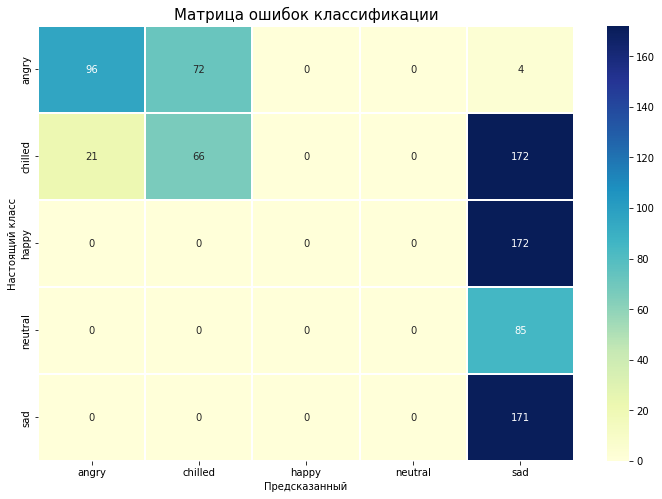

TEST PREDICTIONS:  1
##################################################
Fold:  2
Epoch 1/50
3/4 [=====================>........] - ETA: 0s - loss: 1.6232 - acc: 0.2135
Epoch 00001: val_loss improved from inf to 1.50358, saving model to best_2.h5
4/4 [==============================] - 4s 730ms/step - loss: 1.6218 - acc: 0.2147 - val_loss: 1.5036 - val_acc: 0.1628
Epoch 2/50
3/4 [=====================>........] - ETA: 0s - loss: 1.3189 - acc: 0.2865
Epoch 00002: val_loss improved from 1.50358 to 1.47508, saving model to best_2.h5
4/4 [==============================] - 3s 688ms/step - loss: 1.3158 - acc: 0.2898 - val_loss: 1.4751 - val_acc: 0.2791
Epoch 3/50
3/4 [=====================>........] - ETA: 0s - loss: 1.2437 - acc: 0.3021
Epoch 00003: val_loss improved from 1.47508 to 1.45133, saving model to best_2.h5
4/4 [==============================] - 3s 678ms/step - loss: 1.2439 - acc: 0.3014 - val_loss: 1.4513 - val_acc: 0.2907
Epoch 4/50
3/4 [=====================>........] - ETA: 0s -

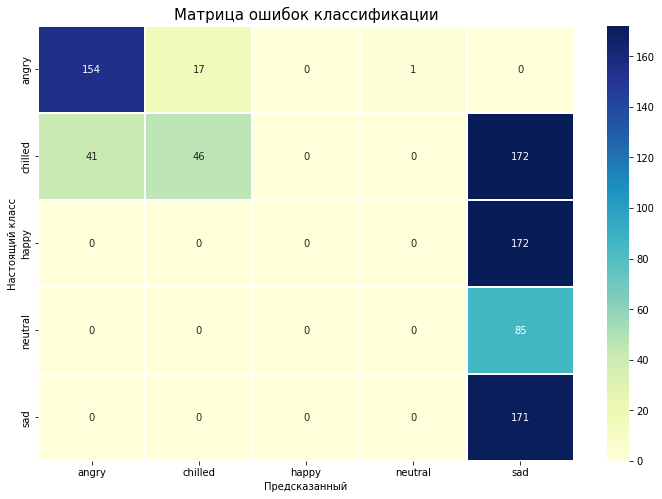

TEST PREDICTIONS:  2
##################################################
Fold:  3
Epoch 1/50
3/4 [=====================>........] - ETA: 0s - loss: 1.6478 - acc: 0.2135
Epoch 00001: val_loss improved from inf to 1.49920, saving model to best_3.h5
4/4 [==============================] - 4s 718ms/step - loss: 1.6463 - acc: 0.2160 - val_loss: 1.4992 - val_acc: 0.1977
Epoch 2/50
3/4 [=====================>........] - ETA: 0s - loss: 1.3990 - acc: 0.3958
Epoch 00002: val_loss improved from 1.49920 to 1.44859, saving model to best_3.h5
4/4 [==============================] - 3s 686ms/step - loss: 1.4024 - acc: 0.3946 - val_loss: 1.4486 - val_acc: 0.4070
Epoch 3/50
3/4 [=====================>........] - ETA: 0s - loss: 1.3077 - acc: 0.4062
Epoch 00003: val_loss improved from 1.44859 to 1.41644, saving model to best_3.h5
4/4 [==============================] - 3s 687ms/step - loss: 1.3062 - acc: 0.4062 - val_loss: 1.4164 - val_acc: 0.4070
Epoch 4/50
3/4 [=====================>........] - ETA: 0s -

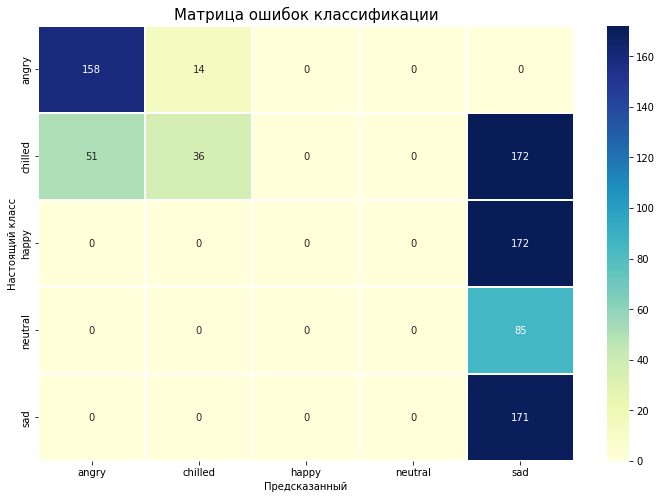

TEST PREDICTIONS:  3
##################################################
Fold:  4
Epoch 1/50
3/4 [=====================>........] - ETA: 0s - loss: 1.5450 - acc: 0.3516
Epoch 00001: val_loss improved from inf to 1.53575, saving model to best_4.h5
4/4 [==============================] - 4s 728ms/step - loss: 1.5460 - acc: 0.3506 - val_loss: 1.5358 - val_acc: 0.4186
Epoch 2/50
3/4 [=====================>........] - ETA: 0s - loss: 1.3227 - acc: 0.3945
Epoch 00002: val_loss improved from 1.53575 to 1.49098, saving model to best_4.h5
4/4 [==============================] - 3s 694ms/step - loss: 1.3207 - acc: 0.3959 - val_loss: 1.4910 - val_acc: 0.4186
Epoch 3/50
3/4 [=====================>........] - ETA: 0s - loss: 1.2672 - acc: 0.4062
Epoch 00003: val_loss improved from 1.49098 to 1.46500, saving model to best_4.h5
4/4 [==============================] - 3s 692ms/step - loss: 1.2694 - acc: 0.4049 - val_loss: 1.4650 - val_acc: 0.3605
Epoch 4/50
3/4 [=====================>........] - ETA: 0s -

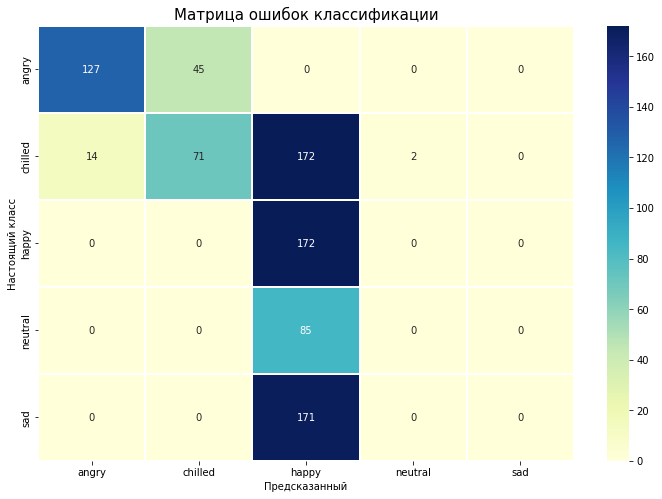

TEST PREDICTIONS:  4
##################################################
Fold:  5
Epoch 1/50
3/4 [=====================>........] - ETA: 1s - loss: 1.9480 - acc: 0.1224
Epoch 00001: val_loss improved from inf to 1.58949, saving model to best_5.h5
4/4 [==============================] - 4s 811ms/step - loss: 1.9463 - acc: 0.1229 - val_loss: 1.5895 - val_acc: 0.0814
Epoch 2/50
3/4 [=====================>........] - ETA: 0s - loss: 1.5066 - acc: 0.2500
Epoch 00002: val_loss improved from 1.58949 to 1.56141, saving model to best_5.h5
4/4 [==============================] - 3s 702ms/step - loss: 1.5096 - acc: 0.2510 - val_loss: 1.5614 - val_acc: 0.1512
Epoch 3/50
3/4 [=====================>........] - ETA: 0s - loss: 1.3636 - acc: 0.3815
Epoch 00003: val_loss improved from 1.56141 to 1.53449, saving model to best_5.h5
4/4 [==============================] - 3s 684ms/step - loss: 1.3631 - acc: 0.3816 - val_loss: 1.5345 - val_acc: 0.3721
Epoch 4/50
3/4 [=====================>........] - ETA: 0s -

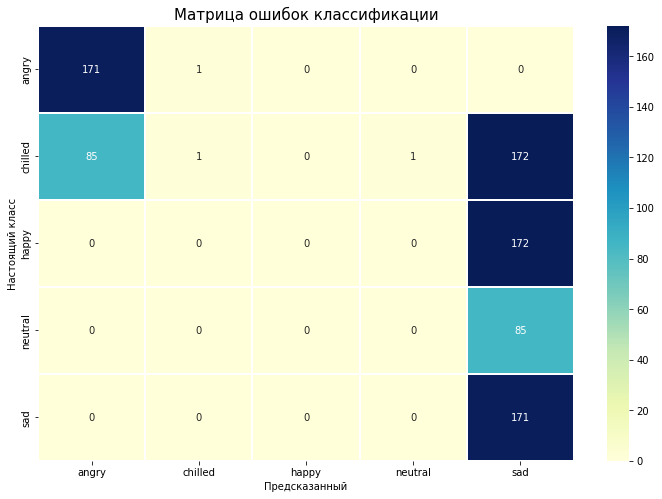

TEST PREDICTIONS:  5
##################################################
Fold:  6
Epoch 1/50
3/4 [=====================>........] - ETA: 0s - loss: 1.8070 - acc: 0.2526
Epoch 00001: val_loss improved from inf to 1.52556, saving model to best_6.h5
4/4 [==============================] - 4s 727ms/step - loss: 1.8062 - acc: 0.2536 - val_loss: 1.5256 - val_acc: 0.5000
Epoch 2/50
3/4 [=====================>........] - ETA: 0s - loss: 1.4454 - acc: 0.3086
Epoch 00002: val_loss improved from 1.52556 to 1.47946, saving model to best_6.h5
4/4 [==============================] - 3s 689ms/step - loss: 1.4474 - acc: 0.3066 - val_loss: 1.4795 - val_acc: 0.5000
Epoch 3/50
3/4 [=====================>........] - ETA: 0s - loss: 1.3205 - acc: 0.3021
Epoch 00003: val_loss improved from 1.47946 to 1.45846, saving model to best_6.h5
4/4 [==============================] - 3s 687ms/step - loss: 1.3209 - acc: 0.3014 - val_loss: 1.4585 - val_acc: 0.5000
Epoch 4/50
3/4 [=====================>........] - ETA: 0s -

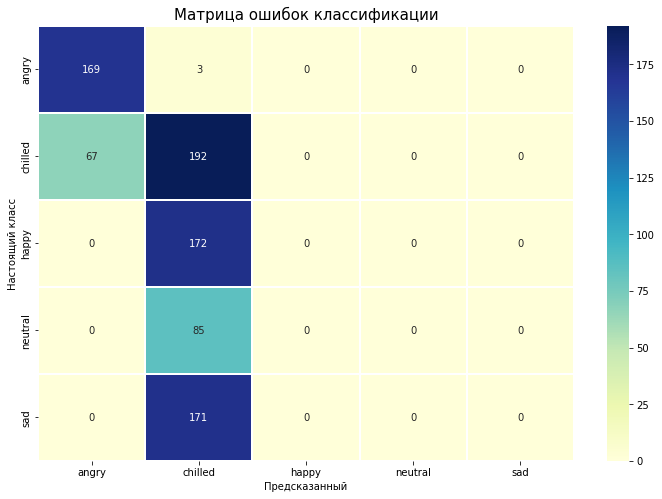

TEST PREDICTIONS:  6
##################################################
Fold:  7
Epoch 1/50
3/4 [=====================>........] - ETA: 0s - loss: 1.8505 - acc: 0.2708
Epoch 00001: val_loss improved from inf to 1.49864, saving model to best_7.h5
4/4 [==============================] - 4s 735ms/step - loss: 1.8507 - acc: 0.2691 - val_loss: 1.4986 - val_acc: 0.3953
Epoch 2/50
3/4 [=====================>........] - ETA: 1s - loss: 1.5577 - acc: 0.3789
Epoch 00002: val_loss improved from 1.49864 to 1.48210, saving model to best_7.h5
4/4 [==============================] - 3s 749ms/step - loss: 1.5581 - acc: 0.3765 - val_loss: 1.4821 - val_acc: 0.3953
Epoch 3/50
3/4 [=====================>........] - ETA: 0s - loss: 1.4702 - acc: 0.3958
Epoch 00003: val_loss improved from 1.48210 to 1.47965, saving model to best_7.h5
4/4 [==============================] - 3s 695ms/step - loss: 1.4706 - acc: 0.3959 - val_loss: 1.4796 - val_acc: 0.3953
Epoch 4/50
3/4 [=====================>........] - ETA: 0s -

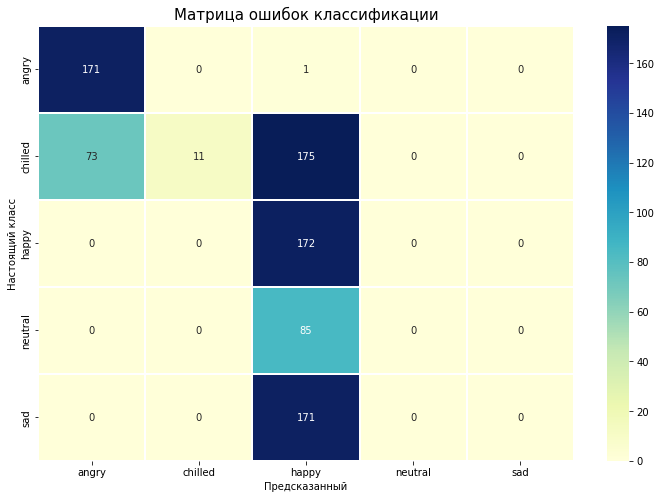

TEST PREDICTIONS:  7
##################################################
Fold:  8
Epoch 1/50
3/4 [=====================>........] - ETA: 0s - loss: 1.7122 - acc: 0.1510
Epoch 00001: val_loss improved from inf to 1.55163, saving model to best_8.h5
4/4 [==============================] - 4s 733ms/step - loss: 1.7080 - acc: 0.1552 - val_loss: 1.5516 - val_acc: 0.4070
Epoch 2/50
3/4 [=====================>........] - ETA: 0s - loss: 1.3265 - acc: 0.3893
Epoch 00002: val_loss improved from 1.55163 to 1.51310, saving model to best_8.h5
4/4 [==============================] - 3s 697ms/step - loss: 1.3268 - acc: 0.3881 - val_loss: 1.5131 - val_acc: 0.3605
Epoch 3/50
3/4 [=====================>........] - ETA: 0s - loss: 1.2600 - acc: 0.4036
Epoch 00003: val_loss improved from 1.51310 to 1.47936, saving model to best_8.h5
4/4 [==============================] - 3s 696ms/step - loss: 1.2606 - acc: 0.4036 - val_loss: 1.4794 - val_acc: 0.3953
Epoch 4/50
3/4 [=====================>........] - ETA: 0s -

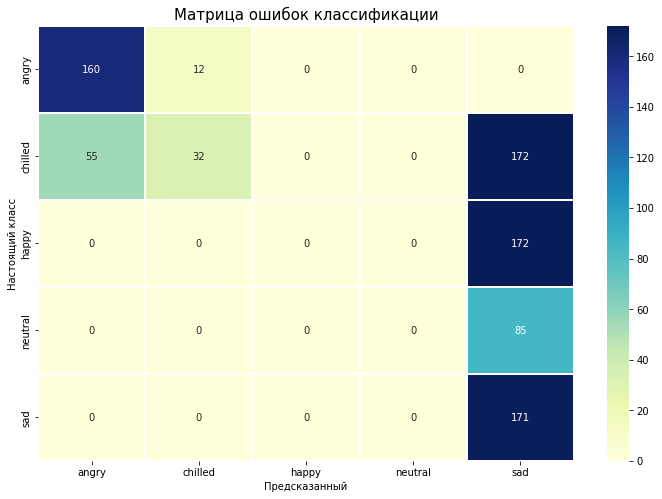

TEST PREDICTIONS:  8
##################################################
Fold:  9
Epoch 1/50
3/4 [=====================>........] - ETA: 0s - loss: 1.9324 - acc: 0.2305
Epoch 00001: val_loss improved from inf to 1.54986, saving model to best_9.h5
4/4 [==============================] - 4s 731ms/step - loss: 1.9355 - acc: 0.2287 - val_loss: 1.5499 - val_acc: 0.2588
Epoch 2/50
3/4 [=====================>........] - ETA: 0s - loss: 1.5731 - acc: 0.3177
Epoch 00002: val_loss improved from 1.54986 to 1.52340, saving model to best_9.h5
4/4 [==============================] - 3s 697ms/step - loss: 1.5718 - acc: 0.3191 - val_loss: 1.5234 - val_acc: 0.4706
Epoch 3/50
3/4 [=====================>........] - ETA: 0s - loss: 1.4323 - acc: 0.3776
Epoch 00003: val_loss improved from 1.52340 to 1.50100, saving model to best_9.h5
4/4 [==============================] - 3s 689ms/step - loss: 1.4316 - acc: 0.3786 - val_loss: 1.5010 - val_acc: 0.5059
Epoch 4/50
3/4 [=====================>........] - ETA: 0s -

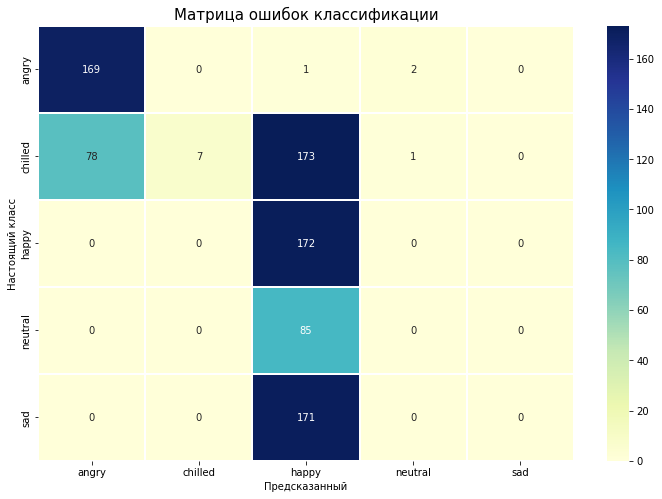

TEST PREDICTIONS:  9


In [ ]:
# Для кросс-валидации используется StratifiedKFold - разновдность KFold алгоритма, которая возвращает
# стратифицированные папки c данными: каждый набор в папке содержит примерно такой же процент выборок каждого целевого класса,
# что и полный набор.
skf = StratifiedKFold(n_splits=config.n_folds)
y_train = df["label"].values
y_train = np.stack(y_train[:])
model = get_2d_conv_model(config)
i = 0
for train_split, val_split in skf.split(X_train, y_train):
    K.clear_session()
    
    # Разделение имеющегося набора данных на тренировочную и валидационные выборки
    X, y, X_val, y_val = X_train[train_split], y_train[train_split], X_train[val_split], y_train[val_split]
    
    # Callback-функции для модели Keras
    # В ходе обучения сохраняем веса лучшей модели для потенциального дальнейшего использования
    checkpoint = ModelCheckpoint('best_%d.h5'%i, monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    callbacks_list = [checkpoint, early]
    print("#"*50)
    print("Fold: ", i)
    model = get_2d_conv_model(config)
    history = model.fit(X, y, validation_data=(X_val, y_val), callbacks=callbacks_list, batch_size=256, epochs=config.max_epochs)
    model.load_weights('best_%d.h5'%i)
    
    # Сохраняем предсказания модели по тренировочным данным
    print("TRAIN PREDICTIONS: ", i)
    predictions = model.predict(X_train, batch_size=256)
    save_train_preds_path = "./predictions/train_predictions_{:d}.npy".format(i)
    np.save(save_train_preds_path, predictions)
    plot_confusion_matrix(predictions, y_train)
    
    # Сохраняем предсказания модели по тестовым данным
    print("TEST PREDICTIONS: ", i)
    predictions = model.predict(X_test, batch_size=256)
    save_test_preds_path = "./predictions/test_predictions_{:d}.npy".format(i)
    np.save(save_test_preds_path, predictions)

    # # Создание файла с результатами (submission)
    # top_3 = np.array(labels)[np.argsort(-predictions, axis=1)[:, :3]]
    # predicted_labels = [' '.join(list(x)) for x in top_3]
    # df_test['label'] = predicted_labels
    # save_preds_path = "./predictions/predictions_{:d}.npy".format(i)
    # df_test[['label']].to_csv(save_preds_path)
    
    j = 0
    for prob in predictions:
        #print(prob)
        #print(np.argmax(prob))
        submission.loc[j,'score'] = max(prob)
        prob_index = list(prob).index(max(prob))
        #print(prob_index)
        submission.loc[j,'label'] = prob_index
        j += 1

    submission_result = submission.copy()
    submission_result['label'] = encode.inverse_transform(np.array(submission['label']).astype(int))
    submission = submission_result
    save_submission_path = "./predictions/submission_{:d}.npy".format(i)
    submission.to_csv(save_submission_path.format(i), index=False)
    
    i += 1